## Orientation detection using markers in time
Keypoint based tracking using similar stragegies as in SLAM-type algorithms.

### 1. Imports

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from helpers.limbus_detection import detect_circle
from helpers.orientation_detection import (
    detect_markers_entropy,
    polar_transform,
)
from helpers.video_manipulation import extract_consecutive


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Extracting consecutive frames

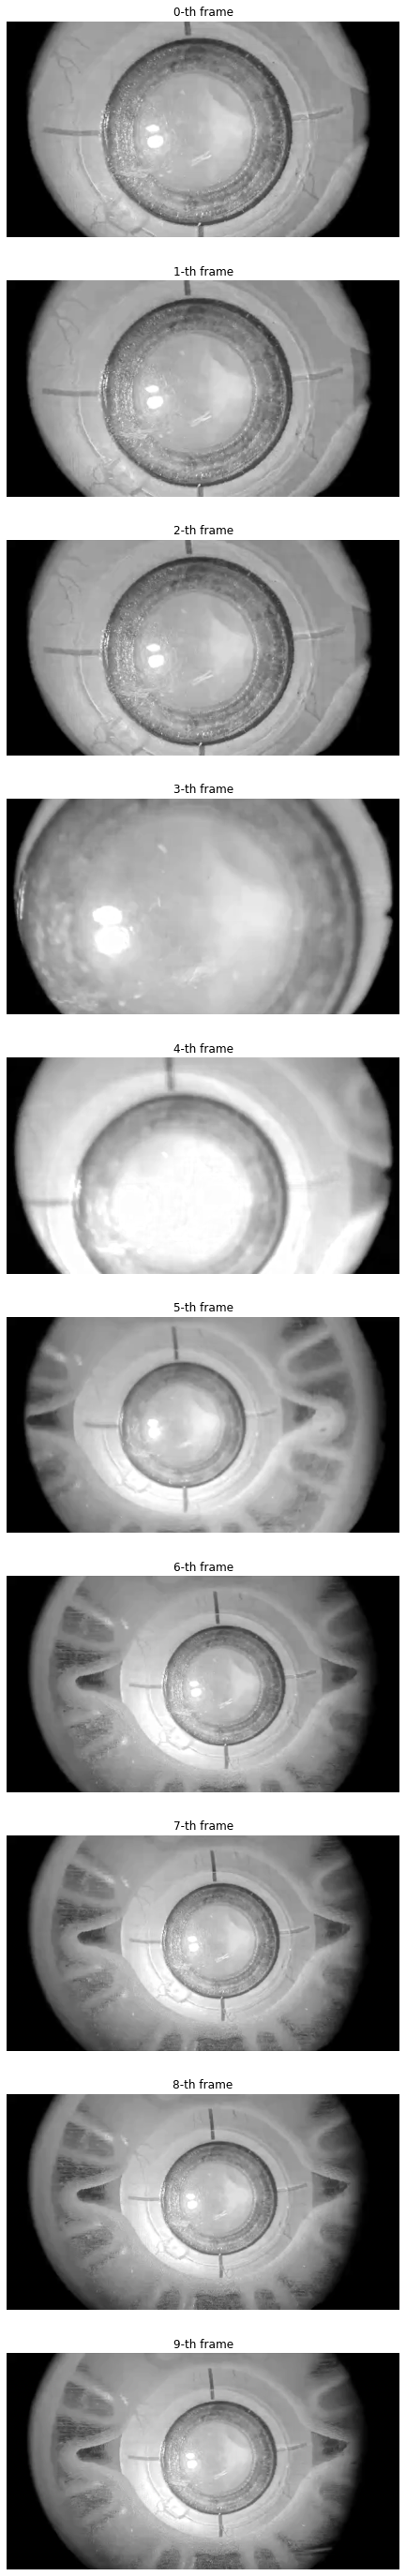

In [43]:
video_path = 'data/artificial/procedure5_lofi.mkv'
# video_path = 'data/artificial/rhexis_input_long_rotating2_lofi.mp4'

frame_start = 51*30
frame_count = 8*30
representatives = 10
frames_full = extract_consecutive(
    video_path, frame_start, frame_start+frame_count, mode='hsv')
frames = []
for i in range(representatives):
    frames.append(frames_full[int(i * (len(frames_full) / representatives))])

_, plots = plt.subplots(len(frames), 1, figsize=(15, 5*len(frames)))
for i, frame in enumerate(frames):
    plots[i].set_title('%s-th frame' % i)
    plots[i].imshow(frame[:, :, 2], cmap='gray')
    plots[i].axis('off')

plt.show()

### 3. precomputing stuff

In [44]:
limbus_circles = []
orientation_degrees = []
polar_segmentations = []
polar_transforms = []

for frame in frames:
    
    circle = detect_circle(frame[:, :, 2], validation='inout')
    degree, _, polar_segmentation, _ = detect_markers_entropy(
        frame, circle[:2], circle[2], return_verbose=True)

#     circle = detect_circle(
#         frame[:, :, 2],
#         validation='inout',
#         validation_mode='max',
#         validation_value_thresh=0.0,
#         considered_ratio_s=1.0,
#         circle_width_to_radius_ratio=0.1,
#         min_radius_ratio=1/10,
#         max_radius_ratio=1/2,
#         max_processing_dim=240,
#         gaussian_blur_sigma=3.0
#     )

    limbus_circles.append(circle)
    orientation_degrees.append(degree)
    polar_segmentations.append(polar_segmentation)
    polar_transforms.append(polar_transform(
        frame[:, :, 2], circle[:2], circle[2]))


### 4. Feature detection visualization

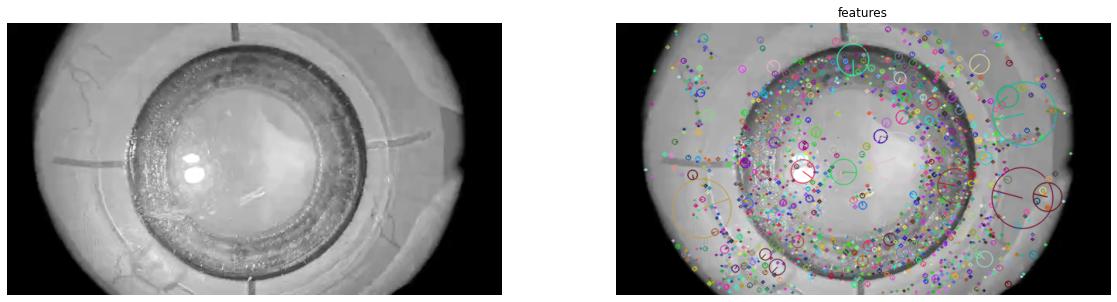

1621 keypoints detected


In [45]:
keypoint_target = frames[0][:, :, 2]

sift = cv2.SIFT_create(contrastThreshold=0.01)
sift_keypoints = sift.detect(keypoint_target, None)

keypoint_target_result = cv2.drawKeypoints(keypoint_target, sift_keypoints, None,
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 5))
plot1.set_title('')
plot1.imshow(keypoint_target, cmap='gray')
plot1.axis('off')

plot2.set_title('features')
plot2.imshow(cv2.cvtColor(keypoint_target_result, cv2.COLOR_BGR2RGB))
plot2.axis('off')

plt.show()

print('%s keypoints detected' % len(sift_keypoints))

### 5. Feature detection + matching

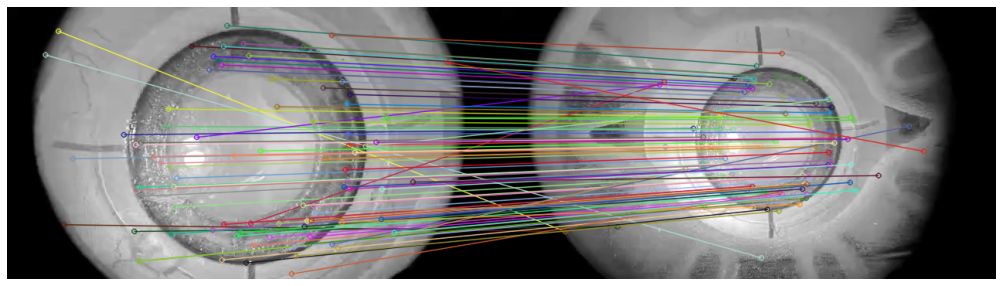

89 good matches found


In [46]:
keypoint_target_from = frames[0][:, :, 2]
keypoint_target_to = frames[-1][:, :, 2]

# SIFT detector initialization
sift = cv2.SIFT_create(contrastThreshold=0.01)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(keypoint_target_from, None)
kp2, des2 = sift.detectAndCompute(keypoint_target_to, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# ratio test
good = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

matches_vis = cv2.drawMatchesKnn(keypoint_target_from, kp1, keypoint_target_to, kp2, good, None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, plot = plt.subplots(1, 1, figsize=(20, 5))
plot.imshow(matches_vis)
plot.axis('off')

plt.show()

print('%s good matches found' % len(good))

### 6. Estimating transformation (scale + rotation + translation) from matches

In [47]:
transform, inliers = cv2.estimateAffinePartial2D(
    np.array([kp1[m[0].queryIdx].pt for m in good]),
    np.array([kp2[m[0].trainIdx].pt for m in good])
)
print(transform)

[[ 6.08031524e-01  6.59261734e-04  1.56175667e+02]
 [-6.59261734e-04  6.08031524e-01  6.11187847e+01]]


In [48]:
def get_transform_info(transform):
    a = transform[0, 0]
    b = transform[1, 0]
    alpha = np.arctan2(b, a)
    s = a / np.cos(alpha)

    print('translation (px): %s, rotation angle (deg): %s, scale: %s' %
          (transform[:, 2], 180*alpha/np.pi, s))

In [49]:
get_transform_info(transform)
print('inliers: %d, total: %d, ratio %f' %
      ((inliers == 1).sum(), inliers.size, (inliers == 1).sum() / inliers.size))

translation (px): [156.17566723  61.11878466], rotation angle (deg): -0.062123259490935064, scale: 0.6080318814730142
inliers: 65, total: 89, ratio 0.730337


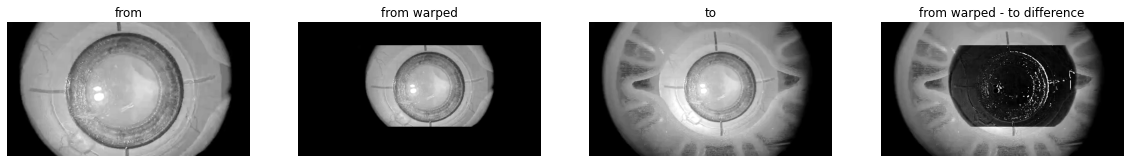

In [50]:
keypoint_target_from_warped = cv2.warpAffine(keypoint_target_from, transform,
                                             (keypoint_target_to.shape[1], keypoint_target_to.shape[0]))

diff = cv2.normalize(keypoint_target_to - keypoint_target_from_warped, None,
                     alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

fig, (plot1, plot2, plot3, plot4) = plt.subplots(1, 4, figsize=(20, 5))
plot1.set_title('from')
plot1.imshow(keypoint_target_from, cmap='gray')
plot1.axis('off')

plot2.set_title('from warped')
plot2.imshow(keypoint_target_from_warped, cmap='gray')
plot2.axis('off')

plot3.set_title('to')
plot3.imshow(keypoint_target_to, cmap='gray')
plot3.axis('off')

plot4.set_title('from warped - to difference')
plot4.imshow(diff, cmap='gray')
plot4.axis('off')

plt.show()